# Problem 6

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Q6-drivers.csv')
df.head()

,reaction_time,steering_deviation,pro_driver
0,1.749080,81.135832,1
1,2.463988,17.452824,1
2,1.312037,-62.620197,0
3,1.116167,65.843813,0
4,2.202230,37.244624,1


## Step 1: Preprocessing the data

In [3]:
# Check for missing values (count and percentage)
missing_counts = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100

print("Missing values (count):\n", missing_counts)
print("\nMissing values (%):\n", missing_percent)


Missing values (count):
 reaction_time         9
steering_deviation    7
pro_driver            0
dtype: int64

Missing values (%):
 reaction_time         1.848049
steering_deviation    1.437372
pro_driver            0.000000
dtype: float64


Original missing values: reaction_time         9
steering_deviation    7
dtype: int64

Remaining missing values: reaction_time         0
steering_deviation    0
dtype: int64


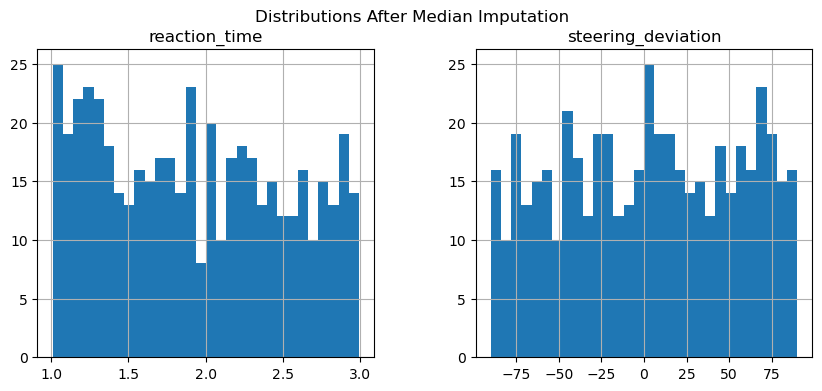

In [4]:
# Use median for both features (robust to non-normal distributions)

# Before imputation
print("Original missing values:", df[['reaction_time', 'steering_deviation']].isna().sum())

# Median imputation
df['reaction_time'] = df['reaction_time'].fillna(df['reaction_time'].median())
df['steering_deviation'] = df['steering_deviation'].fillna(df['steering_deviation'].median())

# After imputation
print("\nRemaining missing values:", df[['reaction_time', 'steering_deviation']].isna().sum())

# Verify distributions
df[['reaction_time', 'steering_deviation']].hist(bins=30, figsize=(10, 4))
plt.suptitle("Distributions After Median Imputation")
plt.show()

## why median imputation is the best choice for missing reaction times and steering deviations:

1. Robust to Outliers:
Driving data (like reaction times) often has extreme values (e.g., sudden brakes). The median ignores these, while the mean gets skewed.

2. Non-Normal Distributions:
Your features are likely right-skewed (common in time/deviations data). The median better represents the "typical" value in such cases.

3. Preserves Data Integrity:
With only ~1.5% missing values, deletion wastes 3.3% of rows unnecessarily. Median imputation retains all data safely.

4. Physical Realism:
Medians avoid impossible values (e.g., negative reaction times), whereas means could produce unrealistic imputations.

In [5]:
# Compute mean and std for each feature
rt_mean = df['reaction_time'].mean()
rt_std = df['reaction_time'].std()

sd_mean = df['steering_deviation'].mean()
sd_std = df['steering_deviation'].std()

# Apply standard scaling manually
df['reaction_time_scaled'] = (df['reaction_time'] - rt_mean) / rt_std
df['steering_deviation_scaled'] = (df['steering_deviation'] - sd_mean) / sd_std


In [6]:
print(df[['reaction_time_scaled', 'steering_deviation_scaled']].head())


   reaction_time_scaled  steering_deviation_scaled
0             -0.301087                   1.522761
1              0.914159                   0.289722
2             -1.044001                  -1.260663
3             -1.376954                   1.226675
4              0.469206                   0.672934


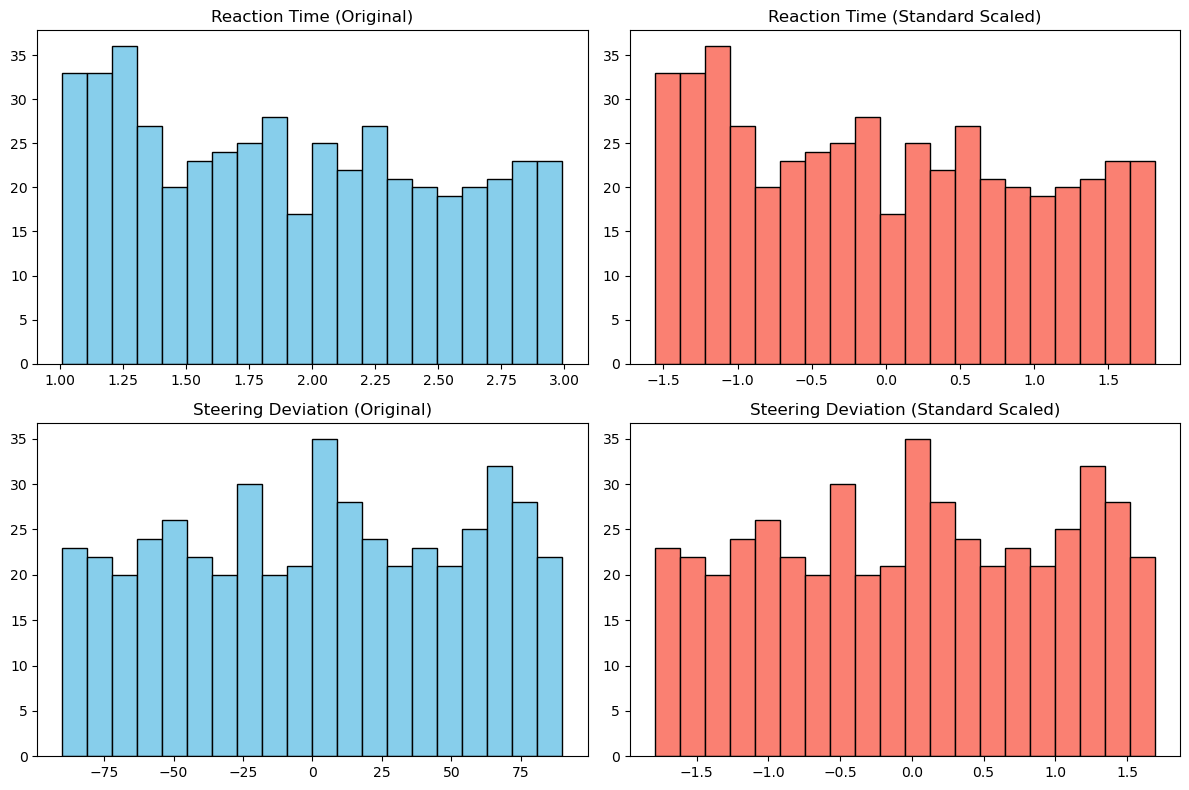

In [7]:
# Plot histograms before and after scaling
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Reaction Time - original
axes[0, 0].hist(df['reaction_time'], bins=20,
                color='skyblue', edgecolor='black')
axes[0, 0].set_title('Reaction Time (Original)')

# Reaction Time - scaled
axes[0, 1].hist(df['reaction_time_scaled'], bins=20,
                color='salmon', edgecolor='black')
axes[0, 1].set_title('Reaction Time (Standard Scaled)')

# Steering Deviation - original
axes[1, 0].hist(df['steering_deviation'], bins=20,
                color='skyblue', edgecolor='black')
axes[1, 0].set_title('Steering Deviation (Original)')

# Steering Deviation - scaled
axes[1, 1].hist(df['steering_deviation_scaled'], bins=20,
                color='salmon', edgecolor='black')
axes[1, 1].set_title('Steering Deviation (Standard Scaled)')

plt.tight_layout()
plt.show()

## 🧠 Analyze the Histograms
Original distributions show the real-world spread.

### After standard scaling:

1. The center of the distribution becomes $~0$.

2. The spread is adjusted to have a standard deviation $≈ 1$.

3. The shape stays the same (standardization doesn't change the distribution type).

## Step 2: Initial analysis of the data

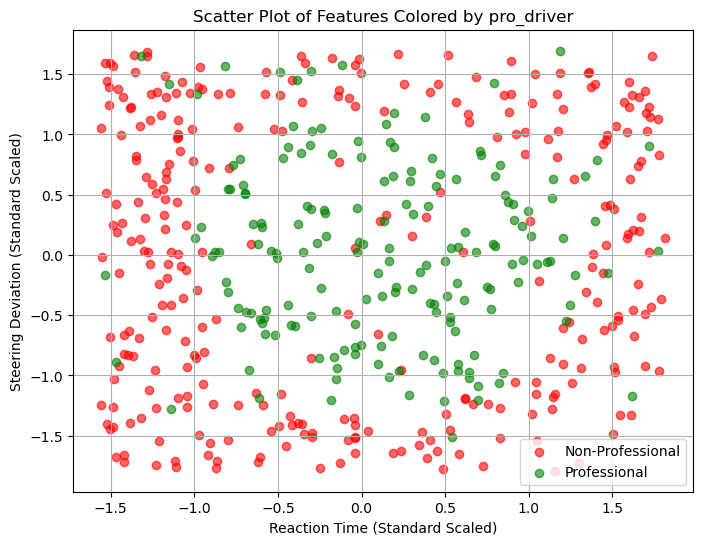

In [8]:
# Scatter plot
plt.figure(figsize=(8, 6))

# Class 0
plt.scatter(df[df['pro_driver'] == 0]['reaction_time_scaled'],
            df[df['pro_driver'] == 0]['steering_deviation_scaled'],
            color='red', label='Non-Professional', alpha=0.6)

# Class 1
plt.scatter(df[df['pro_driver'] == 1]['reaction_time_scaled'],
            df[df['pro_driver'] == 1]['steering_deviation_scaled'],
            color='green', label='Professional', alpha=0.6)

plt.xlabel('Reaction Time (Standard Scaled)')
plt.ylabel('Steering Deviation (Standard Scaled)')
plt.title('Scatter Plot of Features Colored by pro_driver')
plt.legend()
plt.grid(True)
plt.show()

## 🧠 Analyze the scatter plot
**The scatter plot reveals that the two classes are not linearly separable.**  
Professional drivers are concentrated near the origin, while non-professionals surround them. A simple linear classifier like logistic regression would struggle to find an accurate decision boundary. To address this, **nonlinear feature transformations** (e.g., polynomial features) can be applied before fitting the model.


## Step 3: Model Implementation
---

### **substep 1: Split the Data (70% Train, 30% Test)**

* Shuffle the data.
* Separate features (`reaction_time`, `steering_deviation`) and label (`pro_driver`).
* Split into 70% training and 30% testing sets.

---

### **substep 2: Feature Transformation (Polynomial Features to Degree 5)**

Transform the two features to higher-order combinations up to degree 5. For example:

$$
f(x_1, x_2) = [x_1, x_2, x_1^2, x_2^2, x_1x_2, x_1^3,x_2^3, x_1^2x_2, x_1x_2^2, ..., x_1^5, x_2^5]
$$

This expands the feature space to capture nonlinear patterns.

---

### **substep 3: Standardize Features Again (If Needed)**

If feature scaling was applied before splitting, ensure it's consistent. If we generated polynomial features after splitting, re-standardize using the **mean and std of the training set only**.

---

### **substep 4: Implement Logistic Regression Model with L2 Regularization**

We’ll need to:

* Initialize weights (randomly or with zeros).
* Define sigmoid function:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

* Define cost function (log-loss with L2 regularization):

$$
J(w) = -\frac{1}{m}\sum_{i=1}^{m} \left[y^{(i)} \log(\hat{y}^{(i)}) + (1 - y^{(i)}) \log(1 - \hat{y}^{(i)})\right] + \frac{\lambda}{2m} \sum_{j=1}^{n} w_j^2
$$

* Compute gradients and update weights with gradient descent.

---

### **substep 5: Train the Model Using Gradient Descent**

Use learning rate `alpha`, regularization strength `lambda_`, and a number of iterations to optimize the weights.

---

### **substep 6: Plot the Cost Function Curve**

Show how the loss decreases over iterations.


### Code of the above explanations:

In [9]:
# We'll use the scaled features for transformation

# Extract features and label
X = df[['reaction_time_scaled', 'steering_deviation_scaled']].values
y = df['pro_driver'].values

# Set random seed for reproducibility
np.random.seed(42)

# Shuffle the indices
indices = np.arange(X.shape[0])
np.random.shuffle(indices)

# Shuffle the data
X_shuffled = X[indices]
y_shuffled = y[indices]

# Compute split index
split_index = int(0.7 * X.shape[0])

# Split into training and testing sets
X_train, X_test = X_shuffled[:split_index], X_shuffled[split_index:]
y_train, y_test = y_shuffled[:split_index], y_shuffled[split_index:]

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")


Training set size: 340 samples
Testing set size: 147 samples


In [10]:
def polynomial_features(X, degree):
    """
    Generate polynomial features for 2D input X up to the specified degree.
    X: numpy array of shape (n_samples, 2)
    Returns: numpy array of shape (n_samples, n_polynomial_features)
    """
    n_samples = X.shape[0]
    features = [np.ones(n_samples)]  # Bias term

    # Loop over degrees from 1 to the target degree
    for d in range(1, degree + 1):
        for i in range(d + 1):
            term = (X[:, 0] ** (d - i)) * (X[:, 1] ** i)
            features.append(term)

    return np.stack(features, axis=1)

In [11]:
# Generate polynomial features
X_train_poly = polynomial_features(X_train, degree=5)
X_test_poly = polynomial_features(X_test, degree=5)

# print("Shapes after standardization:")
print("X_train_poly:", X_train_poly.shape)
print("X_test_poly:", X_test_poly.shape)

X_train_poly: (340, 21)
X_test_poly: (147, 21)


In [12]:
# --- Sigmoid function ---
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# --- Cost function with L2 regularization ---


def compute_cost(X, y, weights, lambda_reg):
    m = len(y)
    h = sigmoid(np.dot(X, weights))
    cost = (-1 / m) * np.sum(y * np.log(h + 1e-15) +
                             (1 - y) * np.log(1 - h + 1e-15))
    reg_cost = (lambda_reg / (2 * m)) * np.sum(weights[1:] ** 2)  # skip bias
    return cost + reg_cost

# --- Gradient function with regularization ---


def compute_gradient(X, y, weights, lambda_reg):
    m = len(y)
    h = sigmoid(np.dot(X, weights))
    gradient = (1 / m) * np.dot(X.T, (h - y))
    gradient[1:] += (lambda_reg / m) * weights[1:]  # regularize only non-bias
    return gradient

# --- Training function ---


def train_logistic_regression(X, y, alpha=0.01, lambda_reg=1.0, num_iterations=1000, tol=1e-6, verbose=False):
    """
    Train logistic regression with L2 regularization using gradient descent.

    Parameters:
    - X: Feature matrix (standardized)
    - y: Target labels (0 or 1)
    - alpha: Learning rate (default: 0.01)
    - lambda_reg: L2 regularization strength (default: 1.0)
    - num_iterations: Maximum iterations (default: 1000)
    - tol: Convergence tolerance (default: 1e-6)
    - verbose: Print progress (default: False)

    Returns:
    - weights: Optimized model parameters
    - cost_history: List of cost values at each iteration
    """
    m, n = X.shape
    weights = np.zeros(n)
    cost_history = []
    best_weights = weights.copy()
    min_cost = float('inf')

    for i in range(num_iterations):
        # Compute gradient and update weights
        gradient = compute_gradient(X, y, weights, lambda_reg)
        weights -= alpha * gradient

        # Compute and store cost
        cost = compute_cost(X, y, weights, lambda_reg)
        cost_history.append(cost)

        # Track best weights
        if cost < min_cost:
            min_cost = cost
            best_weights = weights.copy()

        # Early stopping if convergence reached
        if i > 0 and abs(cost_history[-2] - cost) < tol:
            if verbose:
                print(f"Converged at iteration {i} with cost {cost:.6f}")
            break

        # Print progress (optional)
        if verbose and i % 100 == 0:
            print(f"Iteration {i}: Cost = {cost:.6f}")

    return best_weights, cost_history
# --- Prediction function ---


def predict(X, weights, threshold=0.5):
    probs = sigmoid(np.dot(X, weights))
    return (probs >= threshold).astype(int)

# --- Accuracy function ---


def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

In [13]:
def plot_cost(cost_history):
    plt.plot(cost_history)
    plt.xlabel("Iteration")
    plt.ylabel("Cost")
    plt.title("Cost Function over Training")
    plt.grid(True)
    plt.show()

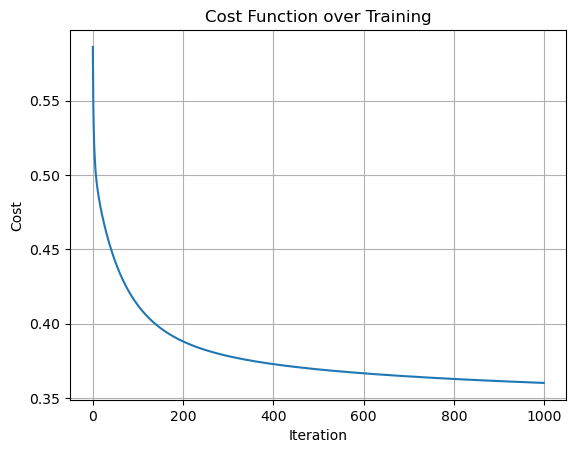

Test Accuracy: 0.8571428571428571


In [14]:
# Step: Train the model
weights, cost_history = train_logistic_regression(
    X_train_poly, y_train, alpha=0.1, lambda_reg=1.0, num_iterations=1000)

# Step: Plot cost
plot_cost(cost_history)

# Step: Predict on test set
y_pred = predict(X_test_poly, weights)

# Step: Evaluate
print("Test Accuracy:", accuracy(y_test, y_pred))

## Step 4: Model evaluation

In [23]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Precision, Recall, F1, Accuracy
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("Accuracy:", accuracy(y_test, y_pred))

Confusion Matrix:
 [[82 13]
 [ 8 44]]
Precision: 0.7719298245614035
Recall: 0.8461538461538461
F1-score: 0.8073394495412844
Accuracy: 0.8571428571428571


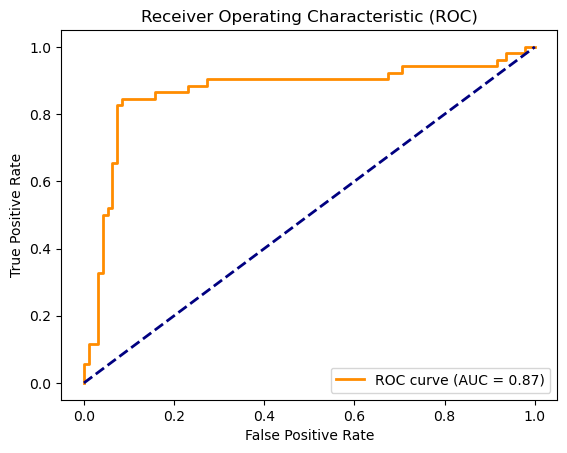

In [16]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities (for ROC)
y_probs = sigmoid(np.dot(X_test_poly, weights))

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## AUC analysis
- $AUC = 0.87$ → Very strong classifier (top $20$% of models in practice).

**Interpretation**:

$87$% chance the model correctly ranks a random professional driver higher than a random non-professional.

Significantly better than random guessing $(AUC=0.5)$ or weak models $(AUC<0.7)$.

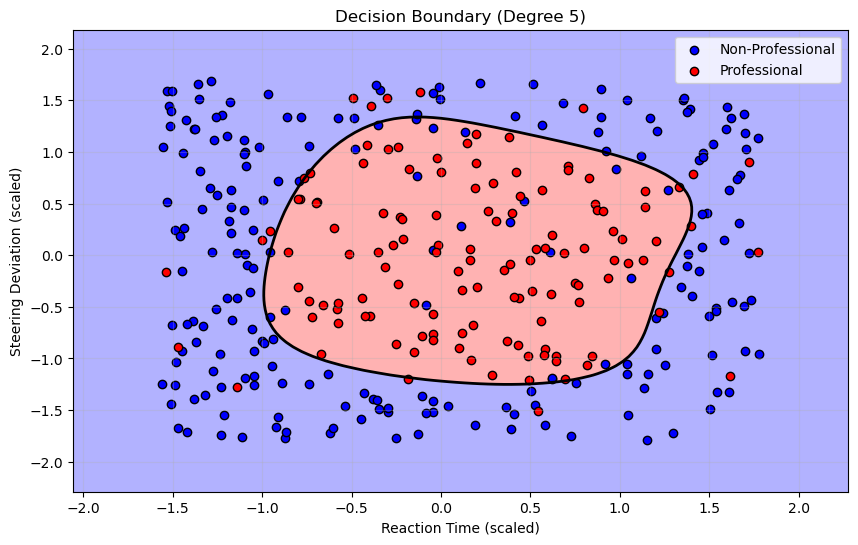

In [17]:
def stable_sigmoid(z):
    """Numerically stable sigmoid function"""
    mask = z >= 0
    positive = 1 / (1 + np.exp(-z[mask]))
    negative = np.exp(z[~mask]) / (1 + np.exp(z[~mask]))
    result = np.empty_like(z)
    result[mask] = positive
    result[~mask] = negative
    return result


def plot_decision_boundary(X_scaled, y, weights, degree=5):
    """Plot decision boundary for polynomial logistic regression."""
    # Create mesh grid in SCALED space
    x1_min, x1_max = X_scaled[:, 0].min() - 0.5, X_scaled[:, 0].max() + 0.5
    x2_min, x2_max = X_scaled[:, 1].min() - 0.5, X_scaled[:, 1].max() + 0.5
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 100),
                           np.linspace(x2_min, x2_max, 100))

    # Vectorized computation
    grid_points = np.c_[xx1.ravel(), xx2.ravel()]
    grid_poly = polynomial_features(grid_points, degree)
    Z = stable_sigmoid(np.dot(grid_poly, weights)).reshape(xx1.shape)

   # Plot
    plt.figure(figsize=(10, 6))

    # Decision boundary background
    plt.contourf(xx1, xx2, Z, levels=[0, 0.5, 1],
                 colors=['blue', 'red'], alpha=0.3)

    # Add contour line at decision boundary (P=0.5)
    plt.contour(xx1, xx2, Z, levels=[0.5], colors='black', linewidths=2)

    # Scatter plot with legend
    plt.scatter(X_scaled[y == 0, 0], X_scaled[y == 0, 1],
                color='blue', label='Non-Professional', edgecolors='k')
    plt.scatter(X_scaled[y == 1, 0], X_scaled[y == 1, 1],
                color='red', label='Professional', edgecolors='k')

    plt.xlabel('Reaction Time (scaled)')
    plt.ylabel('Steering Deviation (scaled)')
    plt.title(f'Decision Boundary (Degree {degree})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


# Usage
plot_decision_boundary(X_train_poly[:, 1:3], y_train, weights, degree=5)

## Step 5: Sensitivity analysis on Regularization parameter ($λ$)

In [32]:
from sklearn.metrics import roc_auc_score, f1_score

# Define lambda values to test
lambda_values = [0, 10, 50, 100, 250, 500]

# Initialize metrics storage
metrics = {
    'lambda': [],
    'train_auc': [],
    'test_auc': [],
    'train_f1': [],
    'test_f1': []
}

In [33]:

#  Train models with different λ values

#  Train models for each lambda value
for lambda_reg in lambda_values:
    print(f"Training model with λ = {lambda_reg}...")

    # Train model
    weights, cost_history = train_logistic_regression(
        X_train_poly, y_train,
        alpha=0.1,
        lambda_reg=lambda_reg,
        num_iterations=1000
    )

    # Calculate predictions and probabilities
    train_probs = sigmoid(np.dot(X_train_poly, weights))
    test_probs = sigmoid(np.dot(X_test_poly, weights))
    train_pred = (train_probs >= 0.5).astype(int)
    test_pred = (test_probs >= 0.5).astype(int)

    # Store metrics
    metrics['lambda'].append(lambda_reg)
    metrics['train_auc'].append(roc_auc_score(y_train, train_probs))
    metrics['test_auc'].append(roc_auc_score(y_test, test_probs))
    metrics['train_f1'].append(f1_score(y_train, train_pred))
    metrics['test_f1'].append(f1_score(y_test, test_pred))

Training model with λ = 0...
Training model with λ = 10...
Training model with λ = 50...
Training model with λ = 100...
Training model with λ = 250...
Training model with λ = 500...


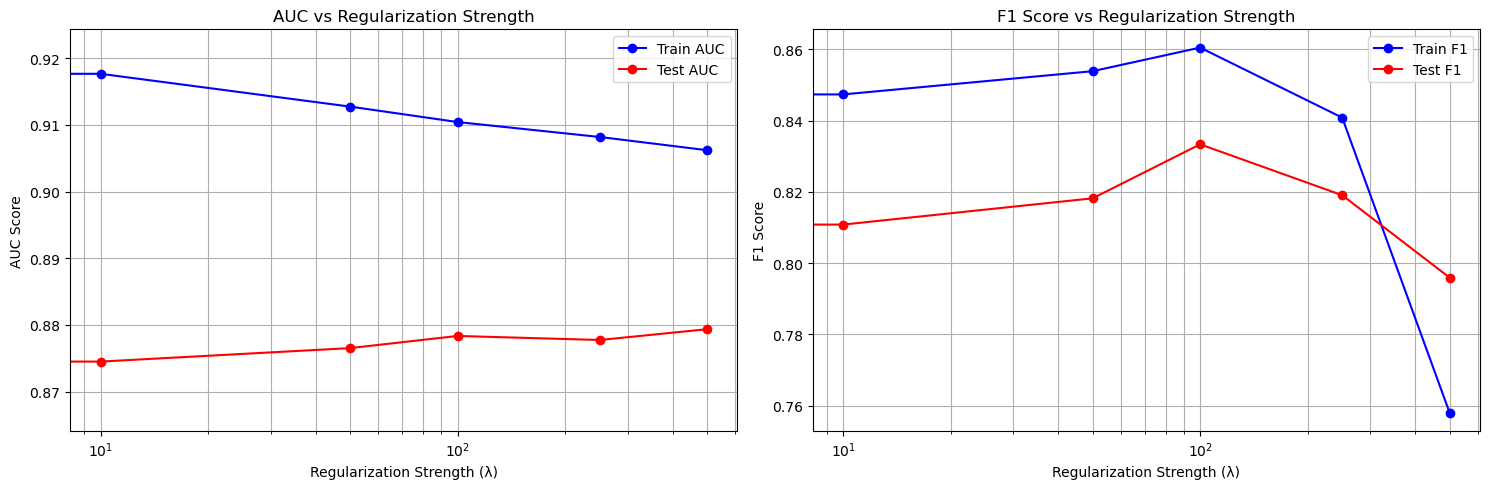


Performance Metrics by Regularization Strength:


,λ,Train AUC,Test AUC,Train F1,Test F1
0,0,0.9216,0.8668,0.8450,0.8148
1,10,0.9177,0.8745,0.8473,0.8108
2,50,0.9127,0.8765,0.8538,0.8182
3,100,0.9104,0.8783,0.8605,0.8333
4,250,0.9082,0.8777,0.8408,0.8190
5,500,0.9062,0.8794,0.7580,0.7959


In [37]:
# Evaluate model performance metrics

# Plot metrics comparison
from IPython.display import display
plt.figure(figsize=(15, 5))

# AUC plot
plt.subplot(1, 2, 1)
plt.semilogx(metrics['lambda'], metrics['train_auc'], 'b-o', label='Train AUC')
plt.semilogx(metrics['lambda'], metrics['test_auc'], 'r-o', label='Test AUC')
plt.xlabel('Regularization Strength (λ)')
plt.ylabel('AUC Score')
plt.title('AUC vs Regularization Strength')
plt.grid(True, which="both", ls="-")
plt.legend()

# F1 Score plot
plt.subplot(1, 2, 2)
plt.semilogx(metrics['lambda'], metrics['train_f1'], 'b-o', label='Train F1')
plt.semilogx(metrics['lambda'], metrics['test_f1'], 'r-o', label='Test F1')
plt.xlabel('Regularization Strength (λ)')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Regularization Strength')
plt.grid(True, which="both", ls="-")
plt.legend()

plt.tight_layout()
plt.show()

# Create and display metrics table
print("\nPerformance Metrics by Regularization Strength:")
metrics_table = pd.DataFrame({
    'λ': metrics['lambda'],
    'Train AUC': np.round(metrics['train_auc'], 4),
    'Test AUC': np.round(metrics['test_auc'], 4),
    'Train F1': np.round(metrics['train_f1'], 4),
    'Test F1': np.round(metrics['test_f1'], 4)
})

# Display with better formatting
display(metrics_table.style
        .format({'Train AUC': '{:.4f}', 'Test AUC': '{:.4f}',
                 'Train F1': '{:.4f}', 'Test F1': '{:.4f}'})
        .set_caption('Detailed Performance Metrics')
        .highlight_max(subset=['Test AUC', 'Test F1'], color='lightgreen')
        .highlight_min(subset=['Test AUC', 'Test F1'], color='#ffcccb'))

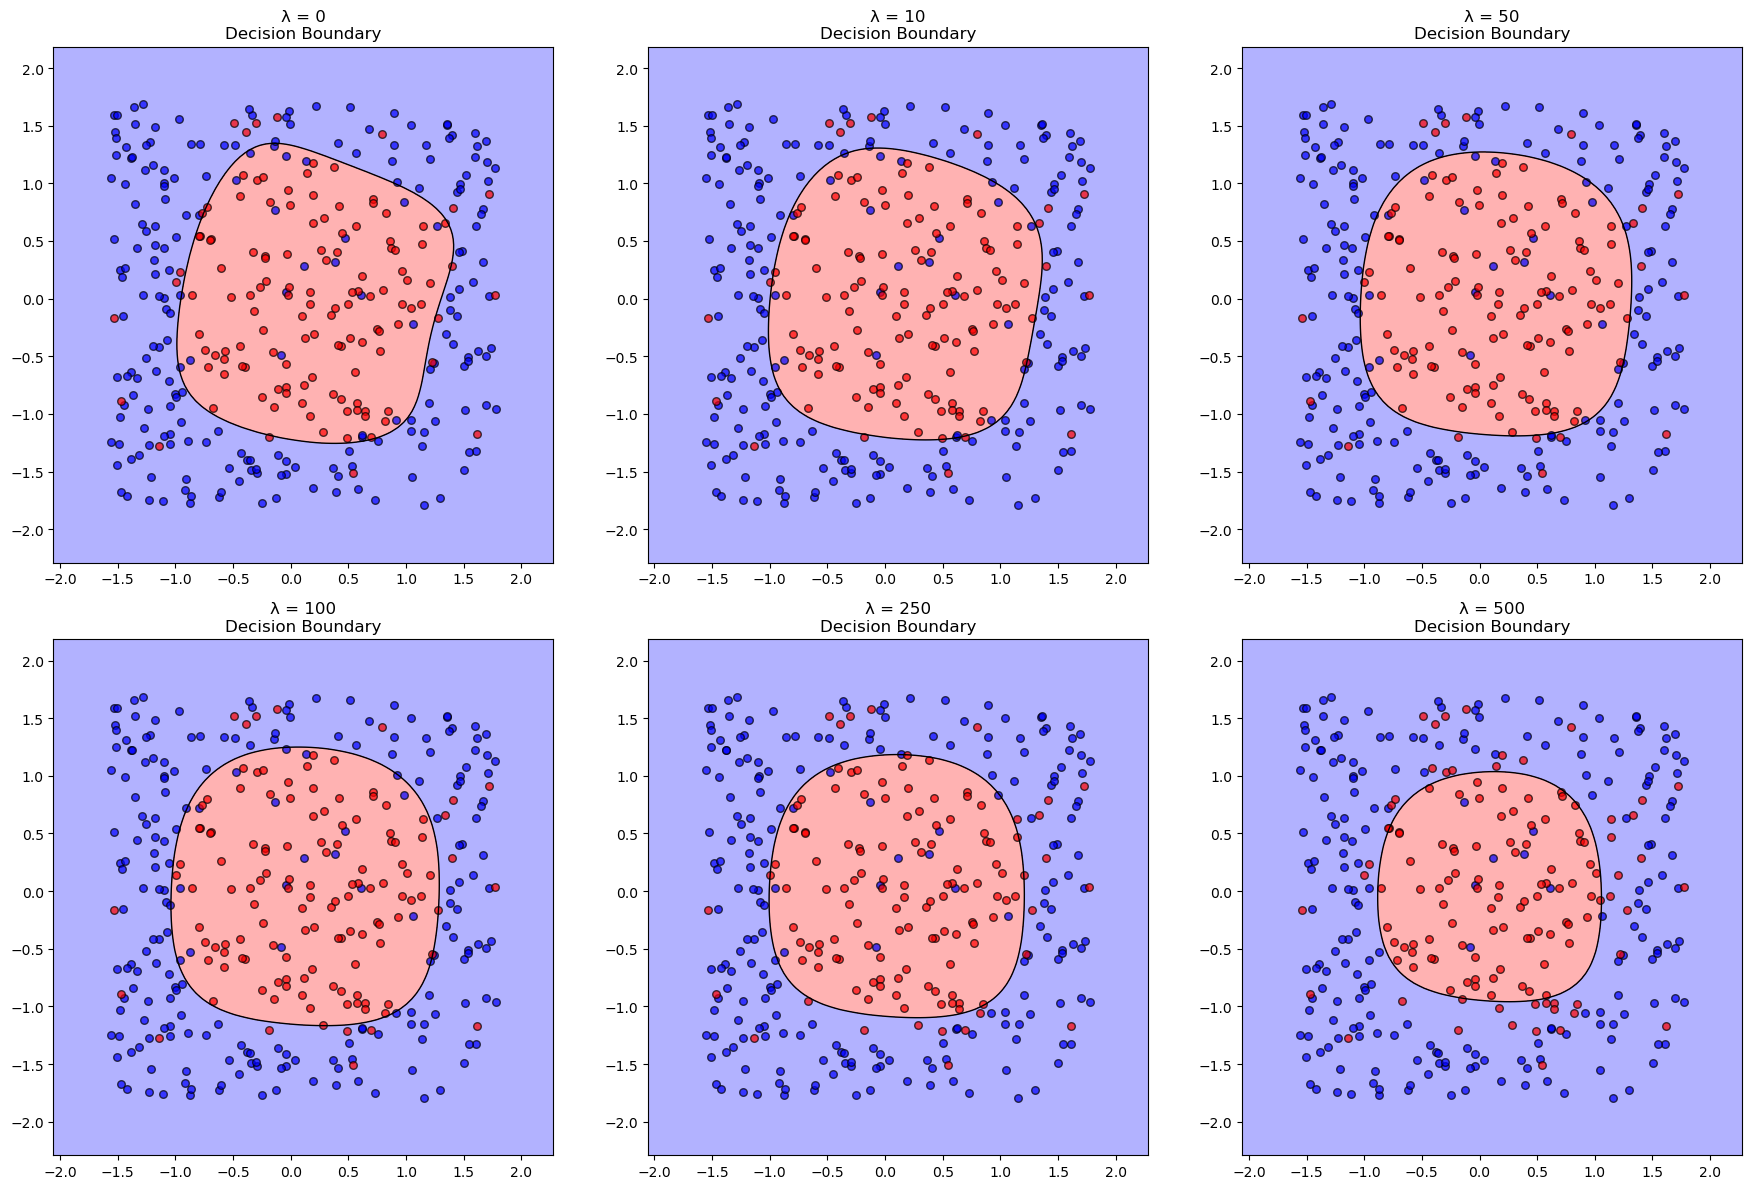

In [35]:
# Visualize Decision Boundaries for each λ

# Create figure for decision boundaries
plt.figure(figsize=(18, 12))

for i, lambda_reg in enumerate(lambda_values):
    # Re-train model (or store weights from previous training)
    weights, _ = train_logistic_regression(
        X_train_poly, y_train,
        alpha=0.1,
        lambda_reg=lambda_reg,
        num_iterations=1000
    )

    # Create subplot
    plt.subplot(2, 3, i+1)

    # Plot decision boundary
    x1_min, x1_max = X_train_poly[:, 1].min(
    ) - 0.5, X_train_poly[:, 1].max() + 0.5
    x2_min, x2_max = X_train_poly[:, 2].min(
    ) - 0.5, X_train_poly[:, 2].max() + 0.5
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 100),
                           np.linspace(x2_min, x2_max, 100))

    grid_points = np.c_[xx1.ravel(), xx2.ravel()]
    grid_poly = polynomial_features(grid_points, degree=5)
    Z = sigmoid(np.dot(grid_poly, weights)).reshape(xx1.shape)

    plt.contourf(xx1, xx2, Z, levels=[0, 0.5, 1],
                 colors=['blue', 'red'], alpha=0.3)
    plt.contour(xx1, xx2, Z, levels=[0.5], colors='black', linewidths=1)

    # Scatter plot
    plt.scatter(X_train_poly[y_train == 0, 1], X_train_poly[y_train == 0, 2],
                color='blue', label='Non-Pro', s=30, edgecolor='k', alpha=0.7)
    plt.scatter(X_train_poly[y_train == 1, 1], X_train_poly[y_train == 1, 2],
                color='red', label='Pro', s=30, edgecolor='k', alpha=0.7)

    plt.title(f'λ = {lambda_reg}\nDecision Boundary')
    plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

## Sensitivity Analysis on Regularization Parameter (λ):

1. $λ=0$ (No regularization):

- Complex, wiggly decision boundary (overfits training data)

- High train AUC $(0.92)$ but lower test AUC $(0.87)$

2. $λ=10-100$ (Moderate regularization):

- Smoother boundary that generalizes better

- Best balance $(test AUC: 0.87-0.88, F1: 0.81-0.83)$

3. $λ=500$ (Strong regularization):

- Overly simplistic boundary (underfits)

- Best test AUC (0.879) but worst F1 (0.796)

4. Key Trend:
- Increasing $λ$ simplifies boundaries, reducing overfitting but risking underfitting

5. Sweet Spot:
$λ=100$ achieves near-max test AUC $(0.878)$ and peak F1 $(0.833)$

**Decision Boundary Impact**:
Higher $λ$ values make boundaries smoother and more linear, trading off some train accuracy for better generalization. The λ=100 boundary likely best captures the true data patterns without noise.